In [1]:
import optuna
from pathlib import Path
import plotly.express as px
import os

In [2]:
original_path = Path(".")
root_path = (Path(".").parent / "../data/baseline_studies/studies/sel/").resolve()
os.chdir(root_path)
p = Path("../images_baseline").resolve()
p.mkdir(exist_ok=True)

In [3]:
study_name = "study-knn_mozilla_200k_1000_samples-_24932448"
study_name = "study-svc_mozilla_200k_1000_samples-_24932435"
study_name = "study-bayesian-networks_mozilla_200k_1000_samples-_24932422"
study = optuna.load_study(study_name=study_name,storage=f"sqlite:///{study_name}.db")

There are 50 trials with 50 completed and 40 skipped due to missing_arameters 14 and due to classifier 40


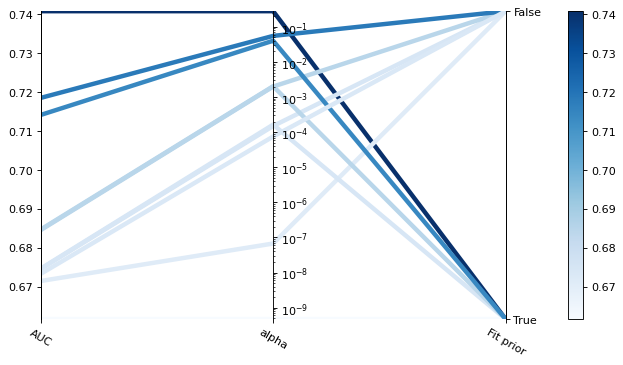

In [20]:
# Extracted from https://optuna.readthedocs.io/en/stable/_modules/optuna/visualization/matplotlib/_parallel_coordinate.html#plot_parallel_coordinate
import matplotlib.pyplot as plt
from optuna.visualization._parallel_coordinate import  _truncate_label #, _get_parallel_coordinate_info
from optuna.visualization._parallel_coordinate import _ParallelCoordinateInfo, _DimensionInfo
from optuna.visualization.matplotlib._matplotlib_imports import Axes
from optuna.visualization.matplotlib._matplotlib_imports import LineCollection
from typing import *
from optuna.study import Study
from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from optuna.visualization._utils import _filter_nonfinite, _is_log_scale, _is_categorical, _is_numerical
# from optuna.visualization._utils import _get_skipped_trial_numbers
import numpy as np
import math
from collections import defaultdict

def _get_skipped_trial_numbers(
    trials: list[FrozenTrial], used_param_names: Sequence[str]
) -> set[int]:
    """Utility function for ``plot_parallel_coordinate``.

    If trial's parameters do not contain a parameter in ``used_param_names``,
    ``plot_parallel_coordinate`` methods do not use such trials.

    Args:
        trials:
            List of ``FrozenTrial``s.
        used_param_names:
            The parameter names used in ``plot_parallel_coordinate``.

    Returns:
        A set of invalid trial numbers.
    """

    skipped_trial_numbers = set()
    for trial in trials:
        for used_param in used_param_names:
            if used_param not in trial.params.keys():
                skipped_trial_numbers.add(trial.number)
                # print(f"Trial missing {used_param} with parameters {trial.params}")
                break
    return skipped_trial_numbers

def _filter_classifier_name(trials, *, filter_classifier_name: str = ""):
    
    skipped_trial_numbers = set()
    for trial in trials:
        if trial.params['classifier_name'] != filter_classifier_name:
            skipped_trial_numbers.add(trial.number)
            # print(f"Trial skipped because not {filter_classifier_name}")
    return skipped_trial_numbers
        
def _get_parallel_coordinate_info(
    study,
    params: Optional[list[str]] = None,
    target: Optional[Callable[[Any], float]] = None,
    target_name: str = "Objective Value",
    filter_classifier_name: str = ""
) -> _ParallelCoordinateInfo:

    reverse_scale = False
    trials = _filter_nonfinite(
        study.get_trials(deepcopy=False, states=(TrialState.COMPLETE,)), target=target
    )
    all_trials = study.get_trials(deepcopy=False)

    all_params = {p_name for t in trials for p_name in t.params.keys()}
    if params is not None:
        for input_p_name in params:
            if input_p_name not in all_params:
                raise ValueError("Parameter {} does not exist in your study.".format(input_p_name))
        all_params = set(params)
    sorted_params = sorted(all_params)

    if target is None:

        def _target(t: FrozenTrial) -> float:
            return cast(float, t.value)

        target = _target

    skipped_trial_numbers_missing_param = _get_skipped_trial_numbers(trials, sorted_params)
    skipped_trial_numbers_classifier = _filter_classifier_name(trials, filter_classifier_name=filter_classifier_name)
    skipped_trial_numbers = skipped_trial_numbers_missing_param.union(skipped_trial_numbers_classifier)
    print(f"There are {len(all_trials)} trials with {len(trials)} completed and {len(skipped_trial_numbers)} skipped due to missing_arameters {len(skipped_trial_numbers_missing_param)} and due to classifier {len(skipped_trial_numbers_classifier)}")

    objectives = tuple([target(t) for t in trials if t.number not in skipped_trial_numbers])
    # The value of (0, 0) is a dummy range. It is ignored when we plot.
    objective_range = (min(objectives), max(objectives)) if len(objectives) > 0 else (0, 0)
    dim_objective = _DimensionInfo(
        label=target_name,
        values=objectives,
        range=objective_range,
        is_log=False,
        is_cat=False,
        tickvals=[],
        ticktext=[],
    )

    if len(trials) == 0:
        print("Your study does not have any completed trials.")
        return _ParallelCoordinateInfo(
            dim_objective=dim_objective,
            dims_params=[],
            reverse_scale=reverse_scale,
            target_name=target_name,
        )

    if len(objectives) == 0:
        print("Your study has only completed trials with missing parameters.")
        return _ParallelCoordinateInfo(
            dim_objective=dim_objective,
            dims_params=[],
            reverse_scale=reverse_scale,
            target_name=target_name,
        )

    numeric_cat_params_indices: list[int] = []
    dims = []
    for dim_index, p_name in enumerate(sorted_params, start=1):
        values = []
        for t in trials:
            if t.number in skipped_trial_numbers:
                continue

            if p_name in t.params:
                values.append(t.params[p_name])

        if _is_log_scale(trials, p_name):
            values = [math.log10(v) for v in values]
            min_value = min(values)
            max_value = max(values)
            tickvals: List[Union[int,float]] = list(range(math.ceil(min_value), math.ceil(max_value)))
            if min_value not in tickvals:
                tickvals = [min_value] + tickvals
            if max_value not in tickvals:
                tickvals = tickvals + [max_value]
            dim = _DimensionInfo(
                label=_truncate_label(p_name),
                values=tuple(values),
                range=(min_value, max_value),
                is_log=True,
                is_cat=False,
                tickvals=tickvals,
                ticktext=["{:.3g}".format(math.pow(10, x)) for x in tickvals],
            )
        elif _is_categorical(trials, p_name):
            vocab: DefaultDict[Union[str,int], int] = defaultdict(lambda: len(vocab))

            ticktext: list[str]
            if _is_numerical(trials, p_name):
                _ = [vocab[v] for v in sorted(values)]
                values = [vocab[v] for v in values]
                ticktext = [str(v) for v in list(sorted(vocab.keys()))]
                numeric_cat_params_indices.append(dim_index)
            else:
                values = [vocab[v] for v in values]
                ticktext = [str(v) for v in list(sorted(vocab.keys(), key=lambda x: vocab[x]))]
            dim = _DimensionInfo(
                label=_truncate_label(p_name),
                values=tuple(values),
                range=(min(values), max(values)),
                is_log=False,
                is_cat=True,
                tickvals=list(range(len(vocab))),
                ticktext=ticktext,
            )
        else:
            dim = _DimensionInfo(
                label=_truncate_label(p_name),
                values=tuple(values),
                range=(min(values), max(values)),
                is_log=False,
                is_cat=False,
                tickvals=[],
                ticktext=[],
            )

        dims.append(dim)

    if numeric_cat_params_indices:
        dims.insert(0, dim_objective)
        # np.lexsort consumes the sort keys the order from back to front.
        # So the values of parameters have to be reversed the order.
        idx = np.lexsort([dims[index].values for index in numeric_cat_params_indices][::-1])
        updated_dims = []
        for dim in dims:
            # Since the values are mapped to other categories by the index,
            # the index will be swapped according to the sorted index of numeric params.
            updated_dims.append(
                _DimensionInfo(
                    label=dim.label,
                    values=tuple(np.array(dim.values)[idx]),
                    range=dim.range,
                    is_log=dim.is_log,
                    is_cat=dim.is_cat,
                    tickvals=dim.tickvals,
                    ticktext=dim.ticktext,
                )
            )
        dim_objective = updated_dims[0]
        dims = updated_dims[1:]

    return _ParallelCoordinateInfo(
        dim_objective=dim_objective,
        dims_params=dims,
        reverse_scale=reverse_scale,
        target_name=target_name,
    )

def plot_parallel_coordinate(
    study,
    params,
    *,
    target = None,
    target_name: str = "Objective Value",
    cmap: str = "Blues_r",
    linewidths: float = 2,
    mapping: Optional[Dict[str,str]] = None,
    figsize: Optional[Tuple[int,int]] = None,
    dpi: int = 300,
    filter_classifier_name: str = "",
):
    info = _get_parallel_coordinate_info(study, params, target=target, target_name=target_name, filter_classifier_name=filter_classifier_name)
    return _get_parallel_coordinate_plot(info, cmap=cmap, linewidths=linewidths, mapping=mapping, figsize=figsize, dpi=dpi)

def _get_parallel_coordinate_plot(
    info, 
    cmap, 
    linewidths, 
    mapping, 
    colorbar: bool = False, 
    figsize: Optional[Tuple[int,int]] = None,
    dpi: int = 300,
):
    target_name = info.target_name
    use_objective = mapping is None or (mapping is not None and "Objective Value" in mapping)
    # Set up the graph style.
    fig, ax = plt.subplots(figsize=figsize,dpi=dpi)
    cmap = plt.get_cmap(cmap)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    # Prepare data for plotting.
    if len(info.dims_params) == 0 or len(info.dim_objective.values) == 0:
        return ax

    obj_min = info.dim_objective.range[0]
    obj_max = info.dim_objective.range[1]
    obj_w = obj_max - obj_min
    dims_obj_base = [[o] for o in info.dim_objective.values]
    # apply the filter
    for dim in info.dims_params:
        p_min = dim.range[0]
        p_max = dim.range[1]
        p_w = p_max - p_min

        if p_w == 0.0:
            center = obj_w / 2 + obj_min
            for i in range(len(dim.values)):
                dims_obj_base[i].append(center)
        else:
            for i, v in enumerate(dim.values):
                dims_obj_base[i].append((v - p_min) / p_w * obj_w + obj_min)
    # Draw multiple line plots and axes.
    # Ref: https://stackoverflow.com/a/50029441
    var_names = [dim.label for dim in info.dims_params]
    if use_objective:
        var_names = [info.dim_objective.label] + var_names
    if mapping is not None:
        var_names = [mapping[v] for v in var_names]
    ax.set_xlim(0, len(info.dims_params))
    ax.set_ylim(min(d[0] for d in dims_obj_base), max(d[0] for d in dims_obj_base))
    xs = [range(len(var_names)) for _ in range(len(dims_obj_base))]
    segments = [np.column_stack([x, y]) for x, y in zip(xs, dims_obj_base)]
    lc = LineCollection(segments, cmap=cmap, linewidths=linewidths)
    lc.set_array(np.asarray(info.dim_objective.values)) # for the colors depending of the objective
    # if colorbar:
    axcb = fig.colorbar(lc, pad=0.1, ax=ax)
        # axcb.set_label(target_name)
    plt.xticks(range(len(var_names)), var_names, rotation=330)

    for i, dim in enumerate(info.dims_params):
        if mapping is not None and dim.label not in mapping:
            continue
        ax2 = ax.twinx()
        if dim.is_log:
            ax2.set_ylim(np.power(10, dim.range[0]), np.power(10, dim.range[1]))
            ax2.set_yscale("log")
        else:
            ax2.set_ylim(dim.range[0], dim.range[1])
        ax2.spines["top"].set_visible(False)
        ax2.spines["bottom"].set_visible(False)
        ax2.xaxis.set_visible(False)
        ax2.spines["right"].set_position(("axes", (i + 1) / len(info.dims_params)))
        if dim.is_cat:
            ax2.set_yticks(dim.tickvals)
            ax2.set_yticklabels(dim.ticktext)

    ax.add_collection(lc)
    return ax
mapping = {'algorithm':'Algorithm','leaf_size':'Leaf size','n_neighbors':'Number of neighbors','p':'p','weights':'Weight'}
mapping = {'C':'C (regularization)','class_weight':'Class weight','coef0':'coef0','decision_function_shape':'Decision fn shape','degree':'Degree', 'kernel': 'Kernel', 'max_iter': 'Max. iterations', 'shrinking':'Shrinking','tol':'Tolerance'}
mapping = {'alpha':'alpha','binarize':'Binarize','fit_prior':'Fit prior','classifier_name':'Classifier name'}
mapping = {'alpha':'alpha','classifier_name':'Classifier name','fit_prior':'Fit prior', 'norm':"Normalization"}
mapping = {'classifier_name':'Classifier name','var_smoothing':'Variable smoothing'}
mapping = {'alpha':'alpha','fit_prior':'Fit prior','Objective Value': 'AUC'}

params = [k for k in mapping if k != "Objective Value"]
fig = plot_parallel_coordinate(study,params,mapping=mapping,cmap="Blues",linewidths=4, figsize=(10,5),dpi=80, filter_classifier_name="BernoulliNB")